In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scipy.stats as scs
from statsmodels.stats.diagnostic import lilliefors
%matplotlib inline

## Podaci

Cilj ovog eseja je usporediti neke podatke o razvijenosti zemalja svijeta i podatke o tome koliko novaca ulažu u obrazovanje.
Zato ću promatrati sljedeće podatke za države svijeta: postotak gradskog stanovništva, prosječna duljina života, BDP per capita (pokazatelji razvijenosti zemlje), postotak BDPa koji se ulaže u obrazovanje, postotak potrošnje vlade na obrazovanje od ukupne potrošnje vlade, postotak potrošnje na obrazovanje koji se odnosi na plaće zaposlenika, zatim kratkoročna ulaganja i konačno dugoročna ulaganja u obrazovanje.

Ovi pokazatelji potrošnje na obrazovanje imaju određena ograničena (vidjeti [ovdje](http://uis.unesco.org/en/glossary-term/expenditure-education-total-government-expenditure-all-sectors) i [ovdje](http://uis.unesco.org/en/glossary-term/government-expenditure-educational-institutions-gdp)): podaci se za neke zemlje odnose samo na Ministarstvo obrazovanja a ne na druga ministarstva koja mogu financirati obrazovanje, također u nekim zemljama je važan udio financiranja obrazovanja iz privatnog sektora pa zato udio financiranja iz javnog sektora može izgledati manji u odnosu na druge zemlje. Nadalje, zemlje s većim udjelom mladog stanovništva moraju trošiti više novca na obrazovanje u odnosu na zemlje koje imaju starije stanovništvo. Za potrebe ovog rada smatramo da su podaci najtočniji mogući jer dolaze od službenih organizacija, ali je važno to imati na umu prilikom interpretacije rezultata.

Podatke uzimam sa stranice http://data.un.org/. Prvo učitavam podatke.

## Učitavanje podataka

In [177]:
data_popc = pd.read_csv('Population Growth Rates in Urban areas and Capital cities.csv', encoding='utf-8')
data_pop = pd.read_csv('Population Growth, Fertility and Mortality.csv', encoding='utf-8')
#data_gen = pd.read_csv('Population, Surface Area and Density.csv', encoding='utf-8')
data_edu = pd.read_csv('Public Expenditure on Education.csv', encoding='utf-8')
data_gdp = pd.read_csv('GDP and GDP Per Capita.csv', encoding='utf-8')

In [178]:
for podaci in (data_popc, data_pop, data_edu, data_gdp):
    podaci.drop(podaci[podaci.Year < 2010].index, inplace=True)

In [179]:
#print(data_popc['Series'].drop_duplicates().to_numpy())
#print(data_pop['Series'].drop_duplicates().to_numpy())
#print(data_edu['Series'].drop_duplicates().to_numpy())
#print(data_gdp['Series'].drop_duplicates().to_numpy())

In [180]:
data_popc.drop(data_popc[data_popc.Series != 'Urban population (percent)'].index, inplace=True)
data_pop.drop(data_pop[data_pop.Series != 'Life expectancy at birth for both sexes (years)'].index, inplace = True)
data_gdp.drop(data_gdp[data_gdp.Series != 'GDP per capita (US dollars)'].index, inplace=True)

In [181]:
izbaci = data_edu.Series.isin(['Expenditure by level of education: primary (as % of government expenditure)',
                               'Expenditure by level of education: secondary (as % of government expenditure)',
                               'Expenditure by level of education: tertiary (as % of government expenditure)',
                               'Expenditure by level of education: pre-primary (as % of government expenditure)'
                              ])
data_edu.drop(data_edu[izbaci].index, inplace=True)

Pretvaram stupce s brojevima iz object u type float64.

In [182]:
data_popc['Value'] = data_popc['Value'].astype(str).astype(float)

In [183]:
data_gdp['Value'] = data_gdp['Value'].astype(str).str.replace(',', '').astype(float)

Sada grupiram vrijednosti po državama (to je stupac 'Unnamed: 1') i računam prosjek.

In [184]:
a = data_popc.groupby('Unnamed: 1')['Value'].mean()
b = data_pop.groupby('Unnamed: 1')['Value'].mean()
c = data_edu.groupby(['Unnamed: 1', 'Series']).mean()
d = data_gdp.groupby('Unnamed: 1')['Value'].mean()

In [185]:
c.reset_index(inplace=True)
#c.Series.drop_duplicates().to_numpy()

In [186]:
c.set_index('Unnamed: 1', inplace=True)

In [187]:
c.head()

,Series,Region/Country/Area,Year,Value
Unnamed: 1,,,,
Afghanistan,All staff compensation as % of total expenditu...,4.0,2012.5,71.912700
Afghanistan,Capital expenditure as % of total expenditure ...,4.0,2012.5,18.955650
Afghanistan,Current expenditure other than staff compensat...,4.0,2012.5,9.131700
Afghanistan,Public expenditure on education (% of GDP),4.0,2014.0,3.543600
Afghanistan,Public expenditure on education (% of governme...,4.0,2014.0,15.079333


U riječniku su svi podaci s kojima radim, njihova kratka imena za lakše korištenje i duga za ispise.

In [188]:
stupci = {'Urban (%)' : 'Urban population (percent)',
          'Life expectancy' :'Life expectancy at birth for both sexes (years)',
          'GDP per capita' : 'GDP per capita (US dollars)',
          'Exp on edu (% of GDP)' : 'Public expenditure on education (% of GDP)',
          'Exp on edu (% of gov exp)' : 'Public expenditure on education (% of government expenditure)',
          'Staff (% of total exp)' : 'All staff compensation as % of total expenditure in public institutions (%)',
          'Current exp (% of total exp)' : 'Current expenditure other than staff compensation\n as % of total expenditure in public institutions (%)',
          'Capital exp (% of total exp)' : 'Capital expenditure as % of total expenditure\n in public institutions (%)'
         }

Konačno sve podatke unosim u DataFrame:

In [189]:
data = pd.DataFrame({'Urban (%)' : a,
              'Life expectancy': b,
              'GDP per capita' : d,
              'Exp on edu (% of GDP)' : c[c.Series=='Public expenditure on education (% of GDP)']['Value'],
              'Exp on edu (% of gov exp)' : c[c.Series=='Public expenditure on education (% of government expenditure)']['Value'],
              'Staff (% of total exp)' : c[c.Series=='All staff compensation as % of total expenditure in public institutions (%)']['Value'],
              'Current exp (% of total exp)' : c[c.Series=='Current expenditure other than staff compensation as % of total expenditure in public institutions (%)']['Value'],
              'Capital exp (% of total exp)' : c[c.Series=='Capital expenditure as % of total expenditure in public institutions (%)']['Value']            
             })

In [190]:
data.head()

,Urban (%),Life expectancy,GDP per capita,Exp on edu (% of GDP),Exp on edu (% of gov exp),Staff (% of total exp),Current exp (% of total exp),Capital exp (% of total exp)
Afghanistan,24.666667,60.9765,593.00,3.5436,15.079333,71.9127,9.1317,18.95565
Albania,56.633333,76.5630,4115.50,3.6963,12.457350,76.0960,15.6955,8.20850
Algeria,70.300000,74.8410,4156.00,NaN,NaN,NaN,NaN,NaN
American Samoa,87.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Andorra,88.400000,NaN,38039.25,3.1265,NaN,36.0915,47.3752,1.20650


In [191]:
data.dropna(inplace=True)

Pogledajmo koje sve države imamo.

In [192]:
data.index.to_numpy()

array(['Afghanistan', 'Albania', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados',
       'Belarus', 'Belgium', 'Benin', 'Bhutan',
       'Bolivia (Plurin. State of)', 'Brazil', 'Brunei Darussalam',
       'Bulgaria', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Chad', 'Colombia', 'Croatia', 'Cyprus', 'Czechia',
       'Côte d’Ivoire', 'Dem. Rep. of the Congo', 'Denmark',
       'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji',
       'Finland', 'France', 'Gambia', 'Germany', 'Ghana', 'Guatemala',
       'Guinea', 'Guinea-Bissau', 'Guyana', 'Honduras', 'Hungary',
       'Iceland', 'Indonesia', 'Iran (Islamic Republic of)', 'Ireland',
       'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan',
       'Kenya', 'Kyrgyzstan', "Lao People's Dem. Rep.", 'Latvia',
       'Lebanon', 'Lesotho', 'Lithuania', 'Luxembourg', 'Madagascar',
       'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Mexico'

## Analiza podataka

In [193]:
data.head()

,Urban (%),Life expectancy,GDP per capita,Exp on edu (% of GDP),Exp on edu (% of gov exp),Staff (% of total exp),Current exp (% of total exp),Capital exp (% of total exp)
Afghanistan,24.666667,60.9765,593.00,3.54360,15.079333,71.91270,9.1317,18.95565
Albania,56.633333,76.5630,4115.50,3.69630,12.457350,76.09600,15.6955,8.20850
Argentina,91.400000,75.2715,13063.25,5.29595,14.212250,84.14395,8.3430,7.51305
Armenia,63.200000,73.3635,3648.25,3.00355,11.298850,82.46800,8.2352,9.29680
Australia,85.633333,81.9195,55678.50,5.44050,14.201700,65.22720,27.1111,7.66170


In [194]:
data.describe()

,Urban (%),Life expectancy,GDP per capita,Exp on edu (% of GDP),Exp on edu (% of gov exp),Staff (% of total exp),Current exp (% of total exp),Capital exp (% of total exp)
count,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000
mean,57.636036,70.366694,15530.063063,4.533950,13.987847,68.524785,22.084718,9.559075
std,23.672273,9.396237,20736.855108,1.482636,4.023870,11.959667,11.231072,7.086279
min,11.900000,45.610500,268.750000,1.332700,2.014433,30.246300,0.876100,0.133300
25%,38.183333,63.852250,1401.750000,3.571600,11.312625,62.934275,15.611900,4.951483
50%,57.133333,73.404500,5694.500000,4.582533,13.471500,70.180650,21.125833,7.909800
75%,77.200000,77.893750,19322.125000,5.459050,16.201900,75.754150,26.826150,11.871000
max,98.833333,82.987000,103730.500000,8.229633,26.701350,98.710700,64.526900,42.460300


U svrhu crtanja histograma podataka zajedno sa grafom normalne razdiobe definiramo funkciju crtaj_histogram.

In [195]:
def crtaj_histogram(data, stupci={}):
    '''Funkcija prima DataFrame i crta histograme frekvencija svih stupaca zajedno sa funkcijom gustoce normalne razdiobe.
    Dodatni (opcionalni) parametar stupci je dictionary kojim se mogu zadavati imena histograma različita od imena stupaca u tablici.
    Ako je parametar stupci prazan rijecnik, onda su imena histograma imena stupaca u tablici.'''
    
    test = lambda br_stupaca : int(br_stupaca/2)+1 if br_stupaca % 2 else int(br_stupaca/2)
    m = test(len(data.columns)) #Broj redaka u subplots
    
    hist, ax = plt.subplots(m, 2, figsize=(15,15))
    hist.tight_layout(pad=4.0)
    j=0
    for row in ax:
        for axis in row:
            if (j<len(data.columns)):
                axis.hist(data.iloc[:,j], density=True, ec = 'black')
                
                mu, sigma = data.iloc[:,j].mean(), data.iloc[:,j].std()
                x = np.linspace(mu - 3*sigma, mu+3*sigma) #znamo da je u normalnoj distribuciji preko 99% podataka na udaljenosti manjoj od 3*std
                y = scs.norm.pdf(x, mu, sigma)
                axis.plot(x, y, color='red', lw=1.4)
                
                if not bool(stupci): #ako je dict prazan, ispisujem imena stupaca
                    axis.set_title(data.columns[j])
                else: #inace koristi dict   
                    axis.set_title(stupci[data.columns[j]])
                axis.set_ylabel('Frequency')
                axis.set_xlabel('')
            else:
                axis.remove()
            j+=1
    #return hist

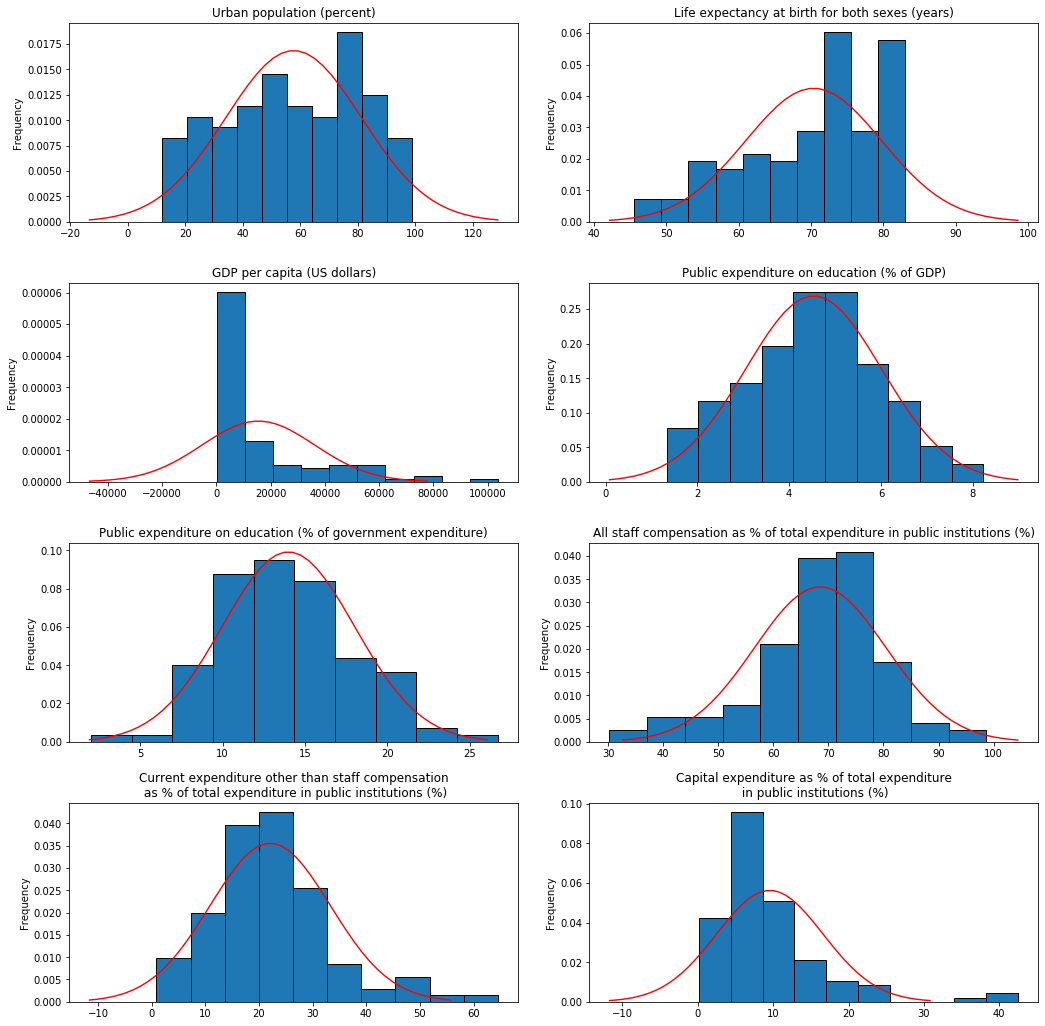

In [196]:
crtaj_histogram(data, stupci)


## Analiza normalnosti podataka

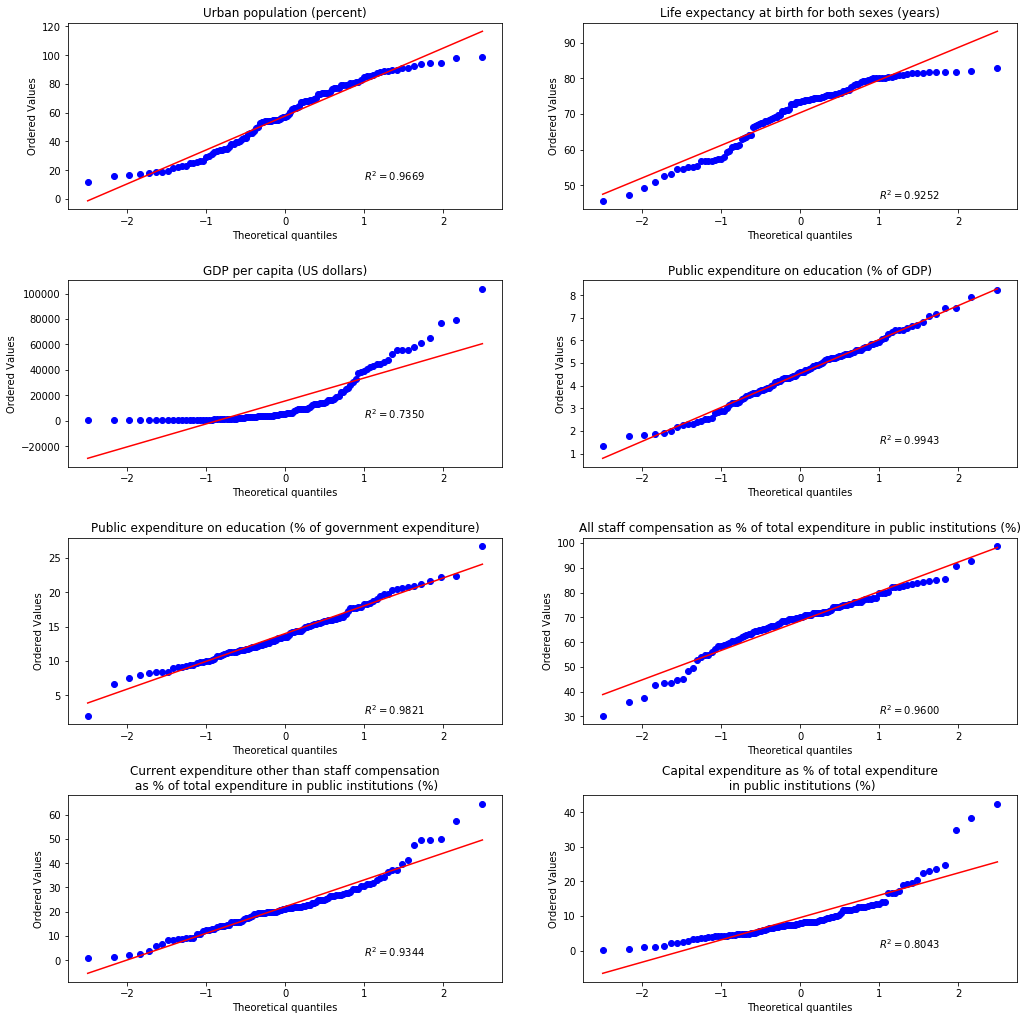

In [197]:
def crtaj_norm_vjer_graf(data, stupci={}):
    
    test = lambda br_stupaca : int(br_stupaca/2)+1 if br_stupaca % 2 else int(br_stupaca/2)
    m = test(len(data.columns)) #Broj redaka u subplots
    
    fig, ax = plt.subplots(m, 2, figsize=(15,15))
    fig.tight_layout(pad=5.0)
    j=0
    for row in ax:
        for axis in row:
            if (j<len(data.columns)):
                stats.probplot(data.iloc[:,j], plot=axis, rvalue=True, dist='norm')
                if not bool(stupci):
                    axis.set_title(data.columns[j])
                else:   
                    axis.set_title(stupci[data.columns[j]])
            else:
                axis.remove()
            j+=1
    #return fig
crtaj_norm_vjer_graf(data,stupci)

In [198]:
def boja(pv):
    boja = 'red' if pv < 0.05 else 'black'
    return 'color: %s' % boja

normal_test = pd.DataFrame([[lilliefors(data[stupac], dist='norm', pvalmethod='table')[1] for stupac in data.columns],
                            [stats.normaltest(data[stupac])[1] for stupac in data.columns],
                            [stats.shapiro(data[stupac])[1] for stupac in data.columns]],
                            columns=data.columns,
                            index=['Lilliefors KS-test', 'normaltest', 'Shapiro'])

normal_test.style.applymap(boja).set_precision(4)

,Urban (%),Life expectancy,GDP per capita,Exp on edu (% of GDP),Exp on edu (% of gov exp),Staff (% of total exp),Current exp (% of total exp),Capital exp (% of total exp)
Lilliefors KS-test,0.0652,0.0010,0.0010,0.9126,0.4285,0.0202,0.0045,0.0010
normaltest,0.0000,0.0058,0.0000,0.6176,0.2700,0.0027,0.0000,0.0000
Shapiro,0.0019,0.0000,0.0000,0.6993,0.2909,0.0035,0.0001,0.0000


P-vrijednosti testova normalnosti su dane u gornjoj tablici. Značajne vrijednosti na razini značajnosti $\alpha = 0.5$ označene su crvenom bojom.

Dakle, za Urban (%), Exp on edu (% of GDP) i Exp on edu (% of gov exp) ne odbacujem pretpostavku da podaci dolaze iz normalno distribuiranih populacija. Current exp (% of total exp) i Capital exp (% of total exp) prema testovima nisu normalno distribuirani ali njihovi histogrami pokazuju da "nisu daleko" od normalnih distribucija. Za ostale podatke niti ne očekujemo da će biti normalno distribuirani.

### Koeficijenti korelacije

Sada računam koeficijente korelacije između parova podataka danih u tablici.
Prvo računam Pearsonov koeficijent korelacije i testiram hipotezu $H_0: \rho = 0$ nasuprot hipotezi $H_1: \rho \neq 0$.
Za testiranje Pearsonovog koeficijenta nužna je pretpostavka o normalnosti podataka. Zato za provjeru računam i Spearsonov koeficijent jer analogan test [ne zahtjeva](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.spearmanr.html) pretpostavku o normalnosti. Pearsonov koeficijent korelacije pokazuje stupanj linearnog odnosa između podataka, a Spearmanov koeficijent stupanje monotone povezanosti podataka ([izvor](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/a-comparison-of-the-pearson-and-spearman-correlation-methods/)).


In [199]:
def korelacija(data, metoda):
    '''Funkcija računa matricu koeficijenata korelacija nad svim kombinacijama stupaca matrica.
    Koeficijenti koji su značajni označeni su s ***. Argumenti funkcije su DataFrame podataka i string koju metodu koristim'''
    if metoda not in {'pearson','spearman'}:
        raise ValueError("argument mora biti 'pearson' ili 'spearman'")
    cor = data.corr(method=metoda)
    for i in data.columns:
        for j in data.columns:
            if metoda == 'pearson':
                ro, pvalue = stats.pearsonr(data[i], data[j])
            else:
                ro, pvalue = stats.spearmanr(data[i], data[j])
            if i == j:
                cor.loc[i,j] = ''
            elif pvalue < 0.05:
                cor.loc[i,j] = '***%.4f' % (cor.loc[i,j])
            else:
                cor.loc[i,j] = '%.4f' % (cor.loc[i,j])
    return cor

In [200]:
korelacija(data, 'pearson')

,Urban (%),Life expectancy,GDP per capita,Exp on edu (% of GDP),Exp on edu (% of gov exp),Staff (% of total exp),Current exp (% of total exp),Capital exp (% of total exp)
Urban (%),,***0.7165,***0.6275,***0.3198,-0.1739,***0.2517,-0.1748,-0.1391
Life expectancy,***0.7165,,***0.6548,***0.2799,***-0.2898,0.0633,0.0563,***-0.1967
GDP per capita,***0.6275,***0.6548,,***0.3502,***-0.2463,0.0622,-0.0153,-0.0930
Exp on edu (% of GDP),***0.3198,***0.2799,***0.3502,,***0.4563,0.0594,0.0286,-0.1844
Exp on edu (% of gov exp),-0.1739,***-0.2898,***-0.2463,***0.4563,,-0.0182,-0.0430,0.0513
Staff (% of total exp),***0.2517,0.0633,0.0622,0.0594,-0.0182,,***-0.8119,***-0.3772
Current exp (% of total exp),-0.1748,0.0563,-0.0153,0.0286,-0.0430,***-0.8119,,***-0.2173
Capital exp (% of total exp),-0.1391,***-0.1967,-0.0930,-0.1844,0.0513,***-0.3772,***-0.2173,


In [201]:
korelacija(data, 'spearman')

,Urban (%),Life expectancy,GDP per capita,Exp on edu (% of GDP),Exp on edu (% of gov exp),Staff (% of total exp),Current exp (% of total exp),Capital exp (% of total exp)
Urban (%),,***0.7382,***0.8013,***0.3028,-0.1806,***0.2159,-0.1497,-0.0594
Life expectancy,***0.7382,,***0.8987,***0.3176,***-0.3203,0.0772,0.0260,-0.0574
GDP per capita,***0.8013,***0.8987,,***0.3694,***-0.3484,0.0431,0.0823,-0.1203
Exp on edu (% of GDP),***0.3028,***0.3176,***0.3694,,***0.4500,0.0333,0.0647,-0.1141
Exp on edu (% of gov exp),-0.1806,***-0.3203,***-0.3484,***0.4500,,0.0419,-0.0406,-0.0296
Staff (% of total exp),***0.2159,0.0772,0.0431,0.0333,0.0419,,***-0.7731,***-0.3555
Current exp (% of total exp),-0.1497,0.0260,0.0823,0.0647,-0.0406,***-0.7731,,-0.1500
Capital exp (% of total exp),-0.0594,-0.0574,-0.1203,-0.1141,-0.0296,***-0.3555,-0.1500,


Oznaka *** uz koeficijent korelacije u tablicama znači da je taj rezultat statistički značajan, odnosno koeficijent korelacije za te dvije varijable je različit od 0.

Vidim da se zaključci o koreliranosti podataka razlikuju za dva slučaja: Capital exp (% of total exp) u odnosu na Life expectancy i Capital exp (% of total exp) u odnosu na Current exp (% of total exp). To su upravo slučajevi kada podaci jako odstupaju od normalnosti.

Nisu svi odnosi u tablici zanimljivi. Očito je da će npr. Staff (% of total exp) i Current exp (% of total exp) biti negativno korelirani jer se radi o postocima istog iznosa.
Međutim, uočavamo nepostojanje koreliranosti zadnja tri retka tablice s ostalim pokazateljima razvijenosti kao što su BDP per capita, očekivano trajanje života ili postotak gradskog stanovništva.
Prikažimo to u dijagramima raspršenja na primjeru postotka potrošnje na zaposlenike od ukupne potrošnje na obrazovanje.

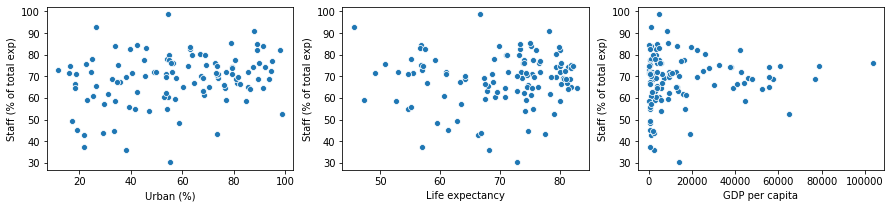

In [202]:
fig, axes = plt.subplots(1, 3, figsize=(15,3))
s1=["Urban (%)", "Life expectancy", "GDP per capita"]
for i in range(len(s1)):
    sns.scatterplot(x = s1[i], y = "Staff (% of total exp)", data=data, ax=axes[i])
#fig

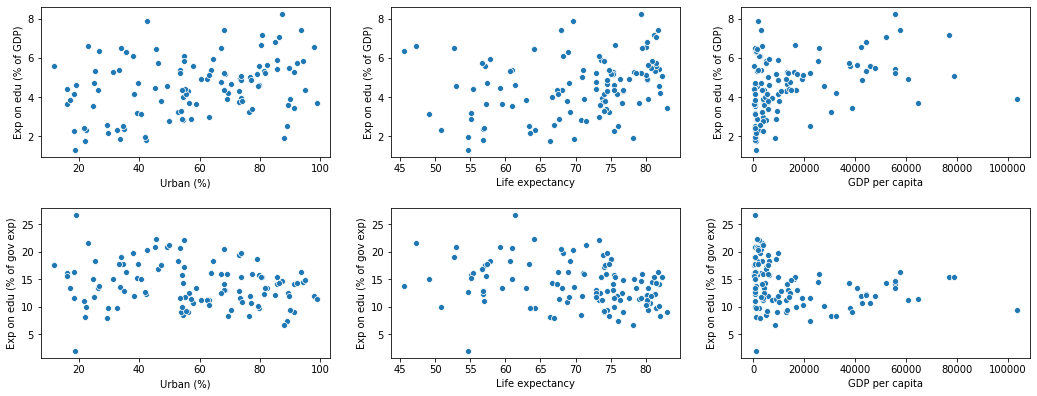

In [203]:
fig, axes = plt.subplots(2, 3, figsize=(15,6))
fig.tight_layout(pad=3.0)
L = ['Urban (%)', 'Life expectancy', 'GDP per capita']
for i in range(len(s1)):
    sns.scatterplot(x = s1[i], y = 'Exp on edu (% of GDP)', data=data, ax=axes[0][i])
    sns.scatterplot(x = s1[i], y = 'Exp on edu (% of gov exp)', data=data, ax=axes[1][i])
#fig

Vidimo da je potrošnja na obrazovanje kao postotka BDP-a slabo pozitivno korelirana (koeficijent korelacije je oko 0.3) s pokazateljima razvijenosti zemlje (BDP per capita, duljina trajanja života, postotak gradskog stanovništva). S druge strane, potrošnja na obrazovanje kao postotka od ukupne potrošnje je slabo negativno korelirana s pokazateljima razvijenosti.

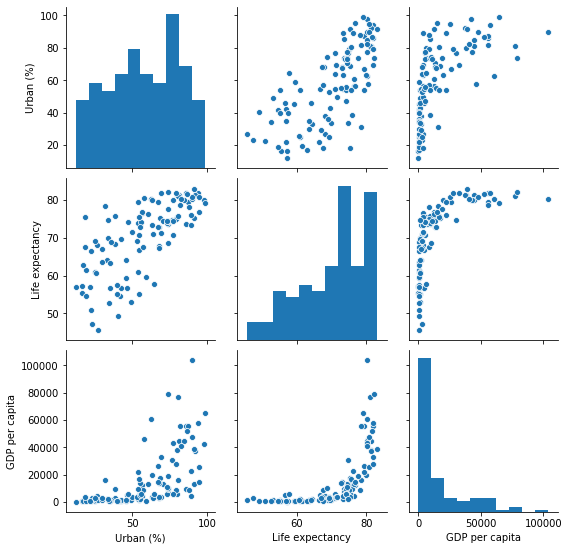

In [204]:
sns.pairplot(data[['Urban (%)', 'Life expectancy', 'GDP per capita']]);

U ova tri slučaja podaci su jako korelirani. U slučaju odnosa BDP per capita i očekivanja trajanja života imamo klasičan primjer kada je odnos monoton (rastući) ali nije linearan. U tom slučaju se ne vidi taj odnos iz Pearsonovog koeficijenta korelacije koji iznosi 0.6548, ali je zato Spearmanov koeficijent korelacije jednak 0.8987.

U interpreataciji rezultata važno je prisjetiti se da korelacija [ne implicira](https://www.mathtutordvd.com/public/Why-Correlation-does-not-Imply-Causation-in-Statistics.cfm) kauzalnost (uzročnost). Pogledajmo to na primjeru korelacije postotka gradskog stanovništva i duljine života. Ljudi (najvjerojatnije) ne žive u prosjeku dulje jer žive u gradovima niti duljina života ne rezultira preseljenjem sa sela u grad, već postoji neki drugi faktor (npr. razvijenost zemlje) koji implicira poklapanje ova dva faktora. Međutim, korelacija može ukazivati na uzročnost. U primjeru BDP-a per capita i duljine života, moguće je da zahvaljujući većem bogatstvu države, bolji zdravstveni sustav produljuje životni vijek stanovništva. Zato su potrebne dodatne analize prije nego što se donosi zaključak. [Ovdje](http://www.tylervigen.com/spurious-correlations) se mogu pronaći zanimljivi primjeri korelacija koji su rezultat slučajnosti.

### Linearna regresija

Radim linearnu regresiju odnosa BDP-a per capita i duljine trajanja života. Iz dijagrama raspršenja vidim da bi bilo dobro logaritmirati podatke o BDPu per capita kako bih dobio linearan odnos.

In [205]:
import statsmodels.api as sm
x = np.log(data['GDP per capita']).values.reshape(-1,1)
y = data['Life expectancy'].values.reshape(-1, 1)
x = sm.add_constant(x)

model = sm.OLS(y, x)
res=model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     311.3
Date:                Sun, 19 Apr 2020   Prob (F-statistic):           1.01e-33
Time:                        18:29:45   Log-Likelihood:                -330.78
No. Observations:                 111   AIC:                             665.6
Df Residuals:                     109   BIC:                             671.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.7964      2.567     10.049      0.000      20.708      30.884
x1             5.1524      0.292     17.642      0.000       4.574       5.731
==============================================================================
Omnibus:                       37.440   Durbin-Watson:                   2.173
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.691
Skew:                          -1.321   Prob(JB):                     6.71e-19
Kurtosis:                       6.334   Cond. No.                         50.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Iz tablice rezultata vidim da je F-statistika jednaka 311.3,a p-vrijednost jako mala pa je model značajan. Koeficijent determinacije iznosi 74% što znači da je 74% varijabilnosti objašnjeno ovim modelom. Koeficijenti u modelu su značajni.

In [206]:
'y = {} + {}*x'.format(res.params[0].round(4), res.params[1].round(4))

'y = 25.7964 + 5.1524*x'

Za linearni regresijski model važno je provjeriti pretpostavku da su reziduali normalno distribuirani, te nacrtati model kako bi provjerili je li model dobar. Naime, može se dogoditi da su gornji pokazatelji dobri, ali da model nije dobar.

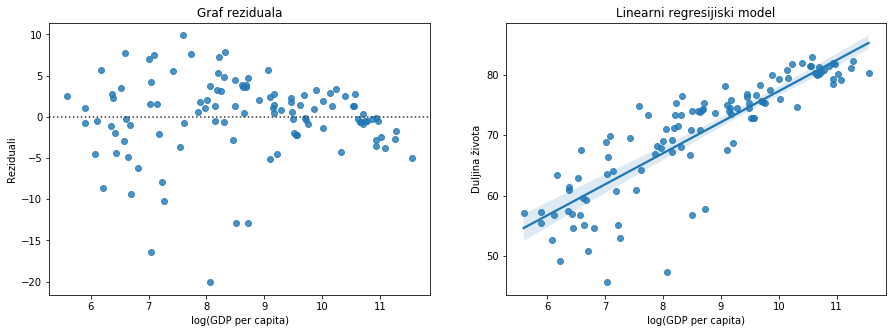

In [207]:
fig, ax=plt.subplots(1,2, figsize=(15,5))
sns.residplot(x[:,1], y, ax=ax[0]);
ax[0].set_title("Graf reziduala")
ax[0].set_xlabel("log(GDP per capita)")
ax[0].set_ylabel("Reziduali")

sns.regplot(x[:,1], y,ax=ax[1]);
ax[1].set_title("Linearni regresijiski model")
ax[1].set_xlabel("log(GDP per capita)")
ax[1].set_ylabel("Duljina života");

Iz grafa rezuduala vidim da su reziduali uglavnom nasumično raspoređeni. Međutim, negativni reziduali imaju veći raspon od pozitivnih. Ovakav graf može ukazivati na to da reziduali nisu normalno distribuirani oko 0 s istim varijancama.

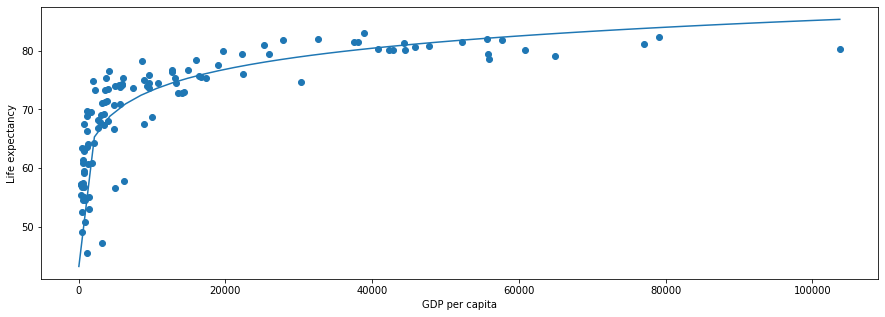

In [208]:
fig, ax=plt.subplots(1,1, figsize=(15,5))
ax.scatter(data["GDP per capita"], data["Life expectancy"]);
x = np.linspace(30, data["GDP per capita"].max())
y = 25.7964 + 5.1524*np.log(x)
ax.plot(x,y);
ax.set_xlabel("GDP per capita");
ax.set_ylabel("Life expectancy");

Nactajmo dobivenu krivulju procjene sa originalnim podacima. Ovo crtam u grafu kojem se može zoomirati i pogledati imena država na koje se dana točkica odnosi.

In [209]:
import plotly.graph_objects as go

tocke = go.Scatter(x=data["GDP per capita"], y=data['Life expectancy'], mode='markers', text=data.index)
x = np.linspace(30, data["GDP per capita"].max())
y = res.params[0].round(4) + res.params[1].round(4)*np.log(x)
procjena = go.Scatter(x=x, y=y, mode='lines')
fig = go.Figure(data=[tocke, procjena])
fig.update_layout(
    title="Dijagram raspršenja sa oznakama država",
    yaxis_title="Life expectancy",
    xaxis_title="GDP per capita")

Vidim da ovaj model nije dobar za veće vrijednosti BDPa per capita jer očekivana duljina života ima neki limes, pa to logaritamska funkcija ne opisuje najbolje.

### Multivarijatni linearni regresijski model

Promatram odnos postotka potrošnje BDPa na obrazovanje u odnosu na postotak gradskog stanovništva, očekivanja života i logaritmiranog BDPa per capita. i radim multivarijatni linearni regresijski model.

In [210]:
data['logGDP'] = np.log(data['GDP per capita'])

In [211]:
X = data[['Urban (%)', 'Life expectancy', 'logGDP']]
Y = data['Exp on edu (% of GDP)']
X=sm.add_constant(X)        #to add constant value in the model
model= sm.OLS(Y,X).fit()         #fitting the model
predictions= model.summary()      #summary of the model
predictions

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Exp on edu (% of GDP)   R-squared:                       0.154
Model:                               OLS   Adj. R-squared:                  0.130
Method:                    Least Squares   F-statistic:                     6.475
Date:                   Sun, 19 Apr 2020   Prob (F-statistic):           0.000455
Time:                           18:29:45   Log-Likelihood:                -191.46
No. Observations:                    111   AIC:                             390.9
Df Residuals:                        107   BIC:                             401.8
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.3458      1.141      2.055      0.042       0.083       4.609
Urban (%)           0.0034      0.009      0.357      0.722      -0.015       0.022
Life expectancy    -0.0293      0.028     -1.060      0.292      -0.084       0.025
logGDP              0.4690      0.194      2.414      0.017       0.084       0.854
==============================================================================
Omnibus:                        1.996   Durbin-Watson:                   2.158
Prob(Omnibus):                  0.369   Jarque-Bera (JB):                2.019
Skew:                           0.310   Prob(JB):                        0.364
Kurtosis:                       2.773   Cond. No.                         815.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### ANOVA

Želim promatrati parametre u odnosu na bogatstvo države. Zato ću podijeliti države na četiri grupe po visini BDPa per capita tako da ih je u svakoj grupi jednako mnogo. Za to su mi potrebni kvantili podataka 'GDP per capita'.

In [212]:
deskriptiva = data['GDP per capita'].describe()
deskriptiva

count       111.000000
mean      15530.063063
std       20736.855108
min         268.750000
25%        1401.750000
50%        5694.500000
75%       19322.125000
max      103730.500000
Name: GDP per capita, dtype: float64

In [213]:
def f(data):
    if data['GDP per capita'] < deskriptiva['25%']:
        val = 1
    elif deskriptiva['25%'] <= data['GDP per capita'] < deskriptiva['50%']:
        val = 2
    elif deskriptiva['50%'] <= data['GDP per capita'] < deskriptiva['75%']:
        val = 3
    else: val = 4
    return val

data['Grupe_BDP'] = data.apply(f, axis=1)

In [214]:
#data.to_excel('novi2.xlsx')

In [216]:
data.rename(columns={'Exp on edu (% of GDP)': 'ExpGDP'}, inplace=True)

In [218]:
from statsmodels.formula.api import ols
results = ols('ExpGDP ~ C(Grupe_BDP)', data=data).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 ExpGDP   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     6.949
Date:                Sun, 19 Apr 2020   Prob (F-statistic):           0.000257
Time:                        18:30:06   Log-Likelihood:                -190.83
No. Observations:                 111   AIC:                             389.7
Df Residuals:                     107   BIC:                             400.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.6934      0.260     14.211      0.000       3.178       4.209
C(Grupe_BDP)[T.2]     0.8256      0.371      2.226      0.028       0.090       1.561
C(Grupe_BDP)[T.3]     0.8582      0.368      2.335      0.021       0.130       1.587
C(Grupe_BDP)[T.4]     1.6779      0.368      4.565      0.000       0.949       2.407
==============================================================================
Omnibus:                        1.735   Durbin-Watson:                   2.191
Prob(Omnibus):                  0.420   Jarque-Bera (JB):                1.773
Skew:                           0.255   Prob(JB):                        0.412
Kurtosis:                       2.648   Cond. No.                         4.77
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""